In [146]:
import pickle
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [147]:
# define the path
data_path = './experiments/learning_curves'
benchmark_path='./experiments/benchmark_files'

alg_dict = {'ma':'MADDPG', 'dd':'DDPG'}
limit_exp_const = 4

In [148]:
# obtain the experiment settings from filename
def exp_attr(fname):
    attrs = {}
    name, suffix = fname.split('.')
    attrs['name'] = name
    attrs['algorithm'], attrs['scenario'], attrs['exp'], attrs['re'] = name.split('_')
    #print(attrs)
    return attrs

# given the experiments results directory, return selected 
# experiment filenames;
# algorithms = [list of algo to be queried]
# scenario = "string of scenario"
def query(path, algorithm, scenario=None, limit_exp = limit_exp_const, reward = 'rewards'):
    fileList = os.listdir(path)
    results = [f for f in fileList if f[-4:]=='.pkl']
    s_flag = (scenario is not None)
    if (not s_flag):
        raise ValueError("Cannot query algorithms")
    if s_flag:
        temp_results = []
        for f in results:
            if len(f.split('.')[0].split('_')) != 4:
                continue
            algo, sc, exp, re = f.split('.')[0].split('_')
            if sc != scenario:
                continue
            if algo != algorithm:
                continue
            if exp[0] != 'e':
                continue
            if int(exp[1:]) > limit_exp:
                continue
            if re != reward:
                continue
            temp_results.append(f)
        results = temp_results
    results = [os.path.join(path, res) for res in results]
    return results

def add_entries(files, scenario, return_time=False):
    columns=['Algorithm','Episode(k)','Reward']
    df = None
    for fname in files:
        f_attr = exp_attr(os.path.basename(fname))
        if f_attr['scenario']!=scenario:
            continue
        alg = f_attr['algorithm']
        #print(alg, attempt, uv)
        data = pickle.load(open(fname, 'rb'))
        for i in range(len(data)):
            results = [[alg_dict[alg], i+1, data[i]]]
            temp_df = pd.DataFrame(results, columns=columns)
            if df is None:
                df = temp_df
            else:
                df = df.append(temp_df,ignore_index=True)
    #print(df)
    return df

def read_reward_for_one_algorithm_one_scenario(path, algo, scenario):
    files = query(path, algo, scenario)
    #print(files)
    return add_entries(files, scenario)

def read_reward_for_one_scenario(scenario):
    ma_data = read_reward_for_one_algorithm_one_scenario(data_path, 'ma', scenario)
    dd_data = read_reward_for_one_algorithm_one_scenario(data_path, 'dd', scenario)
    res = ma_data
    res = res.append(dd_data, ignore_index=True)
    return res

def plt_cooperative_scenario(scenario):
    res = read_reward_for_one_scenario(scenario)
    f = plt.figure(figsize=(10, 8))
    font_size = 25
    with sns.axes_style("darkgrid"):
        sns.lineplot(data=res, \
                     x='Episode(k)', y='Reward', \
                     hue='Algorithm',ci = 100, lw=3)
    plt.xlabel('episode(k)',fontsize=font_size)# x轴标签
    plt.ylabel('mean episode reward', fontsize=font_size)# y轴标签
    plt.legend(fontsize = 18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

# Comparison to Decentralized Reinforcement Learning Methods

## Cooperative Communication scenario

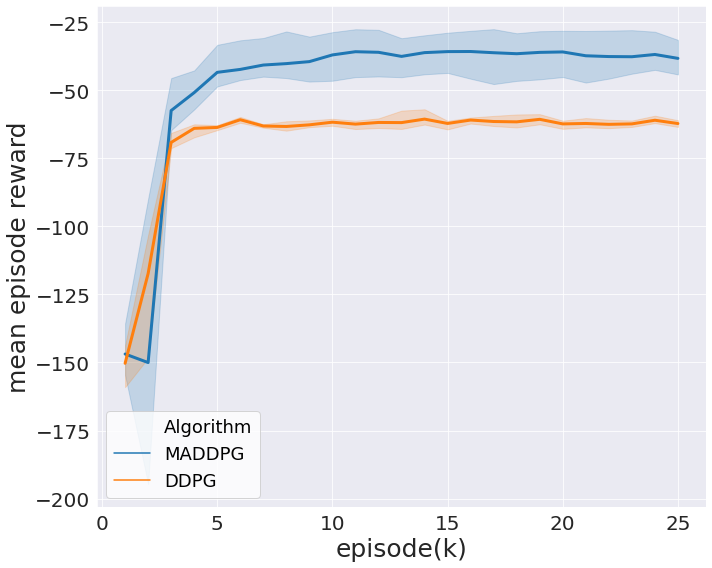

In [149]:
plt_cooperative_scenario('s2')

## Cooperative Navigation scenario

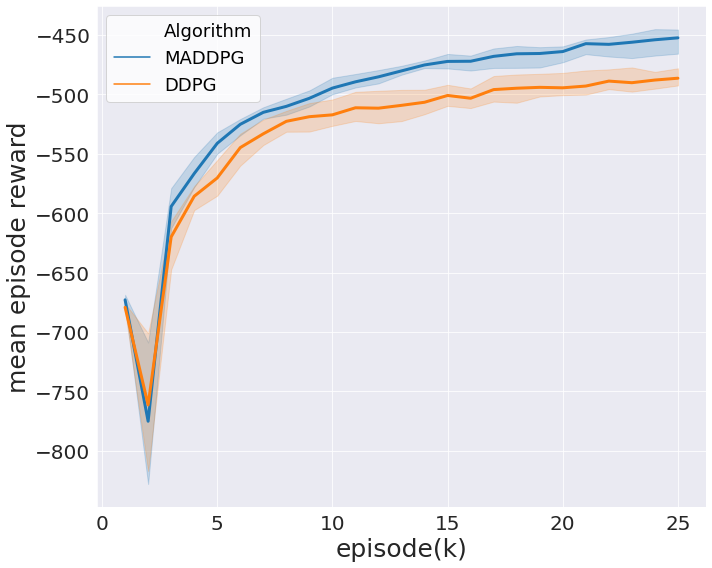

In [150]:
plt_cooperative_scenario('s3')

## Physical Deception scenario

In [151]:
# obtain the experiment settings from filename
def exp_attr_test(fname):
    attrs = {}
    name, suffix = fname.split('.')
    attrs['name'] = name
    attrs['algorithm'], attrs['scenario'], attrs['exp'] = name.split('_')
    #print(attrs)
    return attrs

# given the experiments results directory, return selected 
# experiment filenames;
# algorithms = [list of algo to be queried]
# scenario = "string of scenario"
def query_test(path, algorithm, scenario=None, limit_exp = limit_exp_const):
    fileList = os.listdir(path)
    results = [f for f in fileList if f[-4:]=='.pkl']
    s_flag = (scenario is not None)
    if (not s_flag):
        raise ValueError("Cannot query algorithms")
    if s_flag:
        temp_results = []
        for f in results:
            if len(f.split('.')[0].split('_')) != 3:
                continue
            algo, sc, exp = f.split('.')[0].split('_')
            if sc != scenario:
                continue
            if algo != algorithm:
                continue
            if exp[0] != 'e':
                continue
            if int(exp[1:]) > limit_exp:
                continue
            temp_results.append(f)
        results = temp_results
    results = [os.path.join(path, res) for res in results]
    return results

def get_average_distance(files):
    res = []
    for fname in files:
        good_score = []
        adv_score = []
        data = pickle.load(open(fname, 'rb'))
        for i in range(len(data)):
            adv_score.append(data[i][0][-1][0])
            good_score.append(min(min(data[i][0][-1][1]),min(data[i][0][-1][2])))
        temp = []
        temp.append(np.mean(np.array(good_score)))
        temp.append(np.mean(np.array(adv_score)))
        res.append(temp)
    return res

def get_ratio(data):
    dis_mean = np.mean(np.array(data), axis=0)
    return dis_mean[1]/dis_mean[0]

def show_result_for_physical_deception(path, algo):
    files = query_test(benchmark_path,algo,"s4")
    res = get_average_distance(files)
    if algo == "ma":
        name = "MADDPG VS DDPG"
    else:
        name = "DDPG VS MADDPG"
    print("For Algo " + name)
    print("Dis of Good Agent    Dis of Adversary Agent")
    for good_score, adv_score in res:
        print("{}    {}".format(good_score, adv_score))
    print("mean:")
    dis_mean = np.mean(np.array(res), axis=0)
    print("{}    {}".format(dis_mean[0], dis_mean[1]))
    print("Dis of adversary agent / dis of good agent", get_ratio(res))

In [152]:
show_result_for_physical_deception(benchmark_path,'ma')
show_result_for_physical_deception(benchmark_path,'dd')

For Algo MADDPG VS DDPG
Dis of Good Agent    Dis of Adversary Agent
0.07487963037986375    0.4352294668770683
0.07744830551643334    0.44682030196450423
0.04914061570830536    0.5190529332687642
0.04726217747736436    0.45694326189400786
mean:
0.0621826822704917    0.4645114910010862
Dis of adversary agent / dis of good agent 7.470110230698691
For Algo DDPG VS MADDPG
Dis of Good Agent    Dis of Adversary Agent
0.1277347629176049    0.226524893160088
0.043014649694977654    0.1524557195088352
0.06756771124438685    0.19169754044715817
0.09921888867605047    0.1605698705601254
mean:
0.08438400313325498    0.1828120059190517
Dis of adversary agent / dis of good agent 2.1664296446136144


## Predatory Prey scenario

In [153]:
def count_collision(files):
    res = []
    for fname in files:
        data = pickle.load(open(fname, 'rb'))
        sumtemp = 0
        for i in data:
            for j in i:
                sumtemp += np.array(j).sum()
        res.append(sumtemp)
    return res

def show_result_for_predatory_prey(path, algo):
    if algo == "ma":
        name = "MADDPG VS DDPG"
    else:
        name = "DDPG VS MADDPG"
    print("For Algo " + name)
    files = query_test(benchmark_path,algo,"s7")
    print("Collision times:")
    res = count_collision(files)
    print(res)
    print("Mean of collision times", np.mean(res))
    return

In [154]:
show_result_for_predatory_prey(benchmark_path, 'ma')
show_result_for_predatory_prey(benchmark_path, 'dd')

For Algo MADDPG VS DDPG
Collision times:
[960, 835, 758, 865]
Mean of collision times 854.5
For Algo DDPG VS MADDPG
Collision times:
[993, 1966, 1225, 849]
Mean of collision times 1258.25
